<a href="https://colab.research.google.com/github/samuelFain/course-python_deep_learning/blob/main/python_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Face detection and recognition inference pipeline¶ 

In [32]:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch


fatal: destination path 'facenet_pytorch' already exists and is not an empty directory.


In [42]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [35]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [36]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [37]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [38]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


In [39]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [40]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  ...  paul_rudd  shea_whigham
angelina_jolie        0.000000        1.447480  ...   1.429847      1.399073
bradley_cooper        1.447480        0.000000  ...   1.013447      1.038684
kate_siegel           0.887728        1.313749  ...   1.388377      1.379655
paul_rudd             1.429847        1.013447  ...   0.000000      1.100503
shea_whigham          1.399073        1.038684  ...   1.100503      0.000000

[5 rows x 5 columns]


Face tracking pipeline¶ 

In [46]:
pip install mmcv

     |████████████████████████████████| 307kB 8.1MB/s 
     |████████████████████████████████| 194kB 14.6MB/s 
  Created wheel for mmcv: filename=mmcv-1.3.5-py2.py3-none-any.whl size=438923 sha256=8edbaf521f627e6b42072f0336756972f84423deddae378ffdf7ce014d1a8828
  Stored in directory: /root/.cache/pip/wheels/6f/ec/78/f96171ae1cbdd4e4741baebbe7e88b877e15776e65b457d095
Successfully built mmcv


In [56]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [49]:
mtcnn = MTCNN(keep_all=True, device=device)

In [58]:
video = mmcv.VideoReader('facenet_pytorch/examples/video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]



In [59]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 105
Done


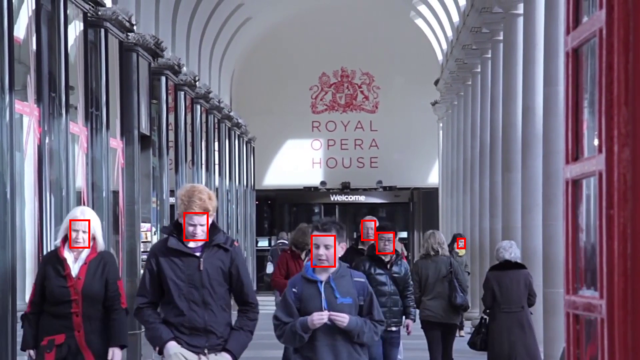

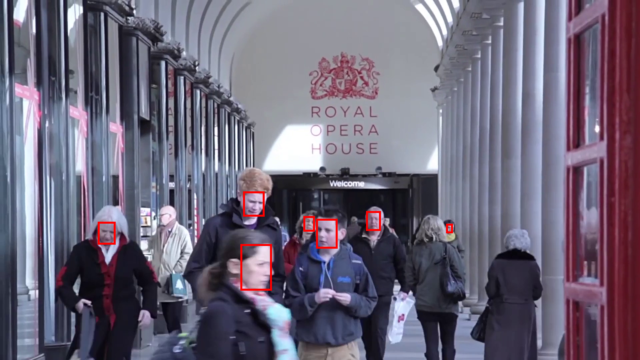

In [ ]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [62]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()
